In [1]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings('ignore', category=ConvergenceWarning)
from IPython.display import clear_output

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import string

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

from Local_Library import arch_volatility_predictor, kalman_filter, data_prep, sharpe_ratio, garch_volatility_predictor
from Local_Library import svr_predictor, arima_predictor, data_prep_arima, data_prep_svr


In [2]:
Ticker_Class_df = pd.read_csv('Ticker_Class_df.csv') # Loading Ticker information from the input csv file.
ETF_df = pd.read_csv('ETF_df.csv') # Loading ETF data from the input csv file.
# ETF_df = ETF_df.iloc[-252*2:,0:5]
# Ticker_Class_df = Ticker_Class_df.iloc[0:5,:]   

In [3]:
def ETF_risk_assignment(risk_value, risk_categories, risk_thresholds):
    # Geneartes and assigns a risk category to a value by referring to risk thresholds. 
    # A one to one mapping is performed between risk categoreis and risk thresholds. 
    # A category is assigned based on the proximity of the value to a threshold.
    # risk_value: value to compare and assign a risk category
    # risk_categories: A list of available risk categories
    # risk_thresholds: A list of risk thresholds
    
    for i in range(len(risk_thresholds)): # Iterating through the threshold values to find the proximity of the value to a threshold.
        if i == 0: # Checks the proximity for threshold values in the range of [0, 0.5)
            if (risk_value >= risk_thresholds[i]) & (risk_value < (risk_thresholds[i]+risk_thresholds[i+1])/2):
                risk_assignment = risk_categories[i]
                break # terminates the for loop if risk boundaries are identified
        elif i+1 < len(risk_thresholds): # Checks the proximity for threshold values in the range of [0.5, ((n-1)+n)/2)
            if (risk_value >= (risk_thresholds[i-1]+risk_thresholds[i])/2) & (risk_value < (risk_thresholds[i]+risk_thresholds[i+1])/2):
                risk_assignment = risk_categories[i]
                break # terminates the for loop if risk boundaries are identified
        else: # Checks the proximity for threshold values in the range of [((n-1)+n)/2, n]
            risk_assignment = risk_categories[i]
    return risk_assignment

In [4]:
def ETF_analysis(Volatility_Predictor, Filter_fun, Risk_Class_fun, ETF_df, Ticker_Class_df, years, risk_count, scale=False, debug=False, Write_to_File=True):
    # Generates summary statistics that include risk, return, sharpe and class.
    # Volatility_Predictor: Input function that predicts ETF volatility.
    # -------------------->Local Library: arch_volatility_predictor | garch_volatility_predictor | SVR_predictor
    # Filter_fun: A filter function to de-noise predictions (kalman_filter).
    # Risk_Class_fun: A function to classify risk into pre-defined categories.
    # ETF_df: Input data frame that contains ETF data.
    # Ticker_Class_df: Input data frame with ETF names and corresponding classes in its columns. Column with ETFs must be named 'Tickers'.
    # years: Number of most recent years worth of data to consider to generate ETF summary statistics.
    # risk_count: Number of risk categories.
    # scale: Boolean. Select if scaling is required. Default is False.
    # debug: Boolean. Returns debug information. Only use in debug mode. Default is False. 
    
    if Volatility_Predictor.__name__ == 'svr_predictor':
        svr_model = SVR(kernel='rbf', C=1000, gamma=0.1)
    
    
    if scale: # Initialiseing scaler if scaling is selected
        scaler = MinMaxScaler()
    
    # Intialising variables to store output data
    ETF_summary = {} # A dictionary is defined to store ETF names as keys and respective summary statistics as values.
    regressor_data_X_debug = [] # empty list to store debug data.
    regressor_data_y_debug = [] # empty list to store debug data.
    lm_fit_debug = [] # empty list to store debug data.

    ETFs = ETF_df.columns # ETF names are extracted from input data frame columns.
    
    
    status_counter = 0 # Initialising a status counter to print the status report while generating summary statistics.
    for ETF in ETFs: # Iterating through each ETF to generate summary statistics.
        summary_stats = {} # Stores summary statistics for each ETF. This is a local dictionary that is reset after each iteration of the for loop.
        clear_output(wait=True) # Clearing previous status print statement.
        print('Generating summary statistics for {} ({}/{})'.format(ETF, status_counter+1, len(ETFs))) # Printing the status update.
        status_counter += 1 # Tracking status.
        
        # Generating ETF data for the current ETF
        ETF_data = ETF_df[[ETF]].dropna() # Removing missing entries if any.
        
        # Generating returns series data for the current ETF
        ETF_returns_df = ETF_data.pct_change() # Calculating ETF returns. Calculated as: (val[1] - val[0])/val[0]).
        # Extracting ETF returns data from last configured number of years and converting to series format.
        ETF_returns_data = pd.Series(ETF_returns_df[ETF][-252*years:]) # Assuming there are 252 trading days in a year.        
        
        # Generating series data for the current ETF     
        if scale: # Scaling the ETF data if scaling is selected.
            ETF_data[ETF] = scaler.fit_transform(ETF_data[[ETF]])
        else: # Using raw ETF data if scaling is not selected.
            ETF_data[ETF] = ETF_data[[ETF]]            
        # Extracting ETF data from last configured number of years and converting to series format.
        ETF_data = pd.Series(ETF_data[ETF][-252*years:])
        
        # Generating ML-model to predict volatility
        if Volatility_Predictor.__name__ == 'arch_volatility_predictor':
            prep_data = data_prep(ETF_returns_data, 'Actual_Return', 22, dropna=True, scale=True) # Using data_prep function from the local library to prepare ETF data for arch volatility predictions.      
            prep_data['X_train_var_predict'] = prep_data['X_train'].apply(lambda x: Volatility_Predictor(x)) # Using lambda function with volatility prediction function to predict volatility for each row of the prepared data.
        elif Volatility_Predictor.__name__ == 'garch_volatility_predictor':
            prep_data = data_prep(ETF_returns_data, 'Actual_Return', 22, dropna=True, scale=True) # Using data_prep function from the local library to prepare ETF data for garch volatility predictions.      
            prep_data['X_train_var_predict'] = prep_data['X_train'].apply(lambda x: Volatility_Predictor(x)) # Using lambda function with volatility prediction function to predict volatility for each row of the prepared data.
        elif Volatility_Predictor.__name__ == 'svr_predictor':
            prep_data = data_prep_svr(ETF_returns_data, 'Actual_Return', 'Actual_Variance', 22, dropna=True, scale=True) # Using data_prep_dl function from the local library to prepare ETF data for svr volatility predictions.  
            prep_data['X_train_var_predict'] = prep_data[['X_train','y_train','X_test']].apply(lambda x: Volatility_Predictor(svr_model,x['X_train'],x['y_train'],x['X_test'])[0], axis=1) # Using lambda function with volatility prediction function to predict volatility for each row of the prepared data.
        elif Volatility_Predictor.__name__ == 'arima_predictor':
            prep_data = data_prep_arima(ETF_returns_data, 'Actual_Return', 'Actual_Variance', 22, dropna=True, scale=True) # Using data_prep_dl function from the local library to prepare ETF data for arima volatility predictions.  
            prep_data['X_train_var_predict'] = prep_data['X_train'].apply(lambda x: Volatility_Predictor(x)[0]) # Using lambda function with volatility prediction function to predict volatility for each row of the prepared data.
            
        else:
            print("Unrecognised volatility_predictor") 
        
        if Volatility_Predictor.__name__ in ['arch_volatility_predictor','garch_volatility_predictor']:
            prep_data['X_train_var_predict_filtered'] = Filter_fun(prep_data['X_train_var_predict'].values) # Using the filter function to de-noise the predictions for improved accuracy.       
        else:
            prep_data['X_train_var_predict_filtered'] = prep_data['X_train_var_predict'] # Ignoring the filter function for the case of SVR.       
        
        summary_stats['Mean_Variance'] = np.mean(prep_data['X_train_var_predict_filtered']) # Generating mean variance summary statistic.       
        
        # Generating a linear regression model to estimate the performance trend of the current ETF over the selected period of time
        regressor_data_X = np.arange(len(ETF_data)).reshape(-1, 1) # Genearating linear data for x-axis.
        regressor_data_y = ETF_data.values # Colledcting the actual data on y-axis.        
        linear_regressor = LinearRegression() # Instantiating a linear regression model.
        lm_fit = linear_regressor.fit(regressor_data_X, regressor_data_y) # Fitting the linear regression model with X and y data.    
        summary_stats['Regressor_Slope'] = lm_fit.coef_[0] # Extracting the slope of the linear regression line which indicated the preformance trend of the current ETF.
        
        # Generating sharpe ratio for the current ETF
        summary_stats['Sharpe'] = sharpe_ratio(ETF_returns_data, 252*years, 0.05) # Using sharpe_ratio function from the local library to generate sharpe ratio.       
        
        # Putting summary statistics for the current ETF together
        ETF_summary[ETF] = summary_stats # Using current ETF name as the key and summary_stats dictionary as the corresponding value in ETF_summary dictionary.
        
        # Collecting data for the debug mode
        if debug:
            regressor_data_X_debug.append(regressor_data_X) # Collecting linear regression X-data for debug mode.
            regressor_data_y_debug.append(regressor_data_y) # Collecting linear regression y-data for debug mode.
            lm_fit_debug.append(lm_fit) # Collecting the fitted linear regression model for the debug mode.
        
    ETF_summary_df = pd.DataFrame(ETF_summary).T # Converting summary statistics dictionary to a data frame.
    ETF_summary_df.reset_index(inplace=True) # Creating a new column with ETF names taken from the data frame index.
    ETF_summary_df.rename(columns={'index': 'Tickers'}, inplace=True) # Renaming the column with ETF names to 'ETF'.
    ETF_summary_df = pd.merge(ETF_summary_df, Ticker_Class_df, on='Tickers', how='left') # Adding ETF class information to the summary statistics data frame.
    
    # Generating risk classifications
    risk_categories = list(string.ascii_uppercase)[: ] # Creating 5 risk categories.
    risk_thresholds = np.linspace(ETF_summary_df.Mean_Variance.min(), ETF_summary_df.Mean_Variance.max(), risk_count) # Generating risk thresholds evenly spaced between min and max risk values.
    ETF_summary_df['Risk_Category'] = ETF_summary_df['Mean_Variance'].apply(
        Risk_Class_fun, args=(risk_categories,risk_thresholds,)).values # Applying a risk category to each risk value ('Mean_Variance' row) in ETF_summary_df.
      
    
    if Write_to_File:
        ETF_summary_df.to_csv('ETF_summary_df.csv', index=False)
    
    clear_output(wait=False)   
    print("Summary statistics generation complete!") # Printing final download status.
    if debug: # Returns ETF_summary along with debug data in the debug mode.
        return ETF_summary_df, regressor_data_X_debug, regressor_data_y_debug, lm_fit_debug, prep_data
    else: # Returns ETF_summary.
        return ETF_summary_df

In [5]:
# arch_volatility_predictor | garch_volatility_predictor | svr_predictor | arima_predictor
[ETF_summary_df, regressor_data_X_debug, regressor_data_y_debug, lm_fit_debug, prep_data] = ETF_analysis(
    arch_volatility_predictor, kalman_filter, ETF_risk_assignment, ETF_df, Ticker_Class_df, 1, 5, False, True, True)
ETF_summary_df.head()

Summary statistics generation complete!


,Tickers,Mean_Variance,Regressor_Slope,Sharpe,Class,Risk_Category
0,EWC,0.923095,0.011811,0.576545,D,C
1,DBC,1.008507,0.000631,-0.399053,B,D
2,FNDX,0.838419,0.040665,1.269875,A,B
3,DDWM,0.829016,0.010440,0.659815,E,B
4,RWK,0.910508,0.073757,0.763167,E,C


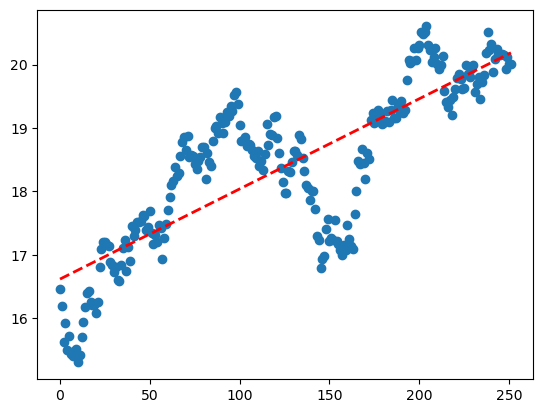

In [6]:
n = 100
plt.scatter(regressor_data_X_debug[n], regressor_data_y_debug[n])
plt.plot(regressor_data_X_debug[n], lm_fit_debug[n].predict(
    regressor_data_X_debug[n]), color='red', linestyle='--', 
         linewidth=2, label='Linear Regression Line')

In [7]:
[ETF_summary_df, regressor_data_X_debug, regressor_data_y_debug, lm_fit_debug, prep_data_arch] = ETF_analysis(
    arch_volatility_predictor, kalman_filter, ETF_risk_assignment, ETF_df.iloc[-252*2:,0:2], Ticker_Class_df.iloc[0:5,:], 1, 5, False, True, False)
ETF_summary_df.sort_values(by='Mean_Variance').head(10)

Summary statistics generation complete!


,Tickers,Mean_Variance,Regressor_Slope,Sharpe,Class,Risk_Category
0,EWC,0.923095,0.011811,0.576545,D,A
1,DBC,1.008507,0.000631,-0.399053,B,E


In [8]:
[ETF_summary_df, regressor_data_X_debug, regressor_data_y_debug, lm_fit_debug, prep_data_garch] = ETF_analysis(
    garch_volatility_predictor, kalman_filter, ETF_risk_assignment, ETF_df.iloc[-252*2:,0:2], Ticker_Class_df.iloc[0:5,:], 1, 5, False, True, False)
ETF_summary_df.sort_values(by='Mean_Variance').head(10)

Summary statistics generation complete!


,Tickers,Mean_Variance,Regressor_Slope,Sharpe,Class,Risk_Category
0,EWC,0.923095,0.011811,0.576545,D,A
1,DBC,1.008507,0.000631,-0.399053,B,E


In [9]:
[ETF_summary_df, regressor_data_X_debug, regressor_data_y_debug, lm_fit_debug, prep_data_svr] = ETF_analysis(
    svr_predictor, kalman_filter, ETF_risk_assignment, ETF_df.iloc[-252*2:,0:2], Ticker_Class_df.iloc[0:5,:], 1, 5, False, True, False)
ETF_summary_df.sort_values(by='Mean_Variance').head(10)

Summary statistics generation complete!


,Tickers,Mean_Variance,Regressor_Slope,Sharpe,Class,Risk_Category
0,EWC,-0.052444,0.011811,0.576545,D,A
1,DBC,0.093897,0.000631,-0.399053,B,E


In [10]:
[ETF_summary_df, regressor_data_X_debug, regressor_data_y_debug, lm_fit_debug, prep_data_arima] = ETF_analysis(
    arima_predictor, kalman_filter, ETF_risk_assignment, ETF_df.iloc[-252*2:,0:2], Ticker_Class_df.iloc[0:5,:], 1, 5, False, True, False)
ETF_summary_df.sort_values(by='Mean_Variance').head(10)

Summary statistics generation complete!


,Tickers,Mean_Variance,Regressor_Slope,Sharpe,Class,Risk_Category
1,DBC,0.059152,0.000631,-0.399053,B,A
0,EWC,0.059868,0.011811,0.576545,D,E
